# Homework - Bayesian modeling - Part A (95 points)
## Bayesian concept learning with the number game

by *Brenden Lake* and *Todd Gureckis*  
Computational Cognitive Modeling  
NYU class webpage: https://brendenlake.github.io/CCM-site/  

<div class="alert alert-danger" role="alert">
This homework is due before midnight on Monday, April 4. 
</div>

In this notebook, you will get hands on experience with Bayesian concept learning and the "number game," as covered in lecture. As with so many of our everyday inferences, the data we receive is far too sparse and noisy to be conclusive. Nevertheless, people must make generalizations and take actions based on imperfect and insufficient data. In data science and machine learning, the situation is often the same: the data is not enough to produce an answer with certainty, yet we can make meaningful generalizations anyway. What computational mechanisms can support these types of inferences?

The number game is a quintessential inductive problem. In the number game, there is an unknown computer program that generates numbers in the range 1 to 100. You are provided with a small set of random examples from this program. For instance, in the figure below, you get two random examples from the program: the numbers '8' and '2'.

<img src="images/number_game_comp.jpeg" style="width: 300px;"/>

Which numbers will also be accepted by the same program? Of course, it depends what the program is, and you don't have enough information to be sure. Should '9' be accepted? Perhaps, if the concept is "all numbers up to 10." What about '10'? A better candidate, since the program could again be "numbers up to 10", or "all even numbers." What about '16'? This is another good candidate, and the program "powers of 2" is also consistent with the examples so far. How should one generalize based on the evidence so far? This homework explores how the Bayesian framework provides an answer to this question.

<div class="alert alert-info">
The number game was introduced in the following paper:
<ul>
<li>Tenenbaum, J. B. (2000). Rules and similarity in concept learning. In Advances in Neural Information Processing Systems (NIPS).</li>
</ul>
This is assignment is adapted from exercises developed by Josh Tenenbaum.
</div>

### The Bayesian model
In the number game, we receive a set of $n$ positive examples $X = \{x^{(1)},...,x^{(n)}\}$ of an unknown concept $C$. In a Bayesian analysis of the task, the goal is predict $P(y \in C\ |\ X)$, which is the probability that a new number $y$ is also a member of the concept $C$ after receiving the set of examples $X$.

#### Updating beliefs with Bayes' rule
Let's proceed with the Bayesian model of the task. There is a hypothesis space $H$ of concepts, where a particular member of the hypothesis space (i.e., a particular concept) is denoted $h \in H$. The Bayesian model includes a prior distribution $P(h)$ over the hypotheses and a likelihood $P(X|h)$. Bayes' rule specifies how to compute the posterior distribution over hypotheses given these two pieces:
\begin{equation}
P(h|X) = \frac{P(X|h)P(h)}{\sum_{h' \in H} P(X|h')P(h')}
\end{equation}
The likelihood is specified below. We will leave the prior to later.

#### Likelihood
We assume that each number in $X$ is an independent sample from the set of all valid numbers. Thus, the likelihood decomposes as a product of individual probabilities,
\begin{equation}
P(X|h) = \prod_{i=1}^n P(x^{(i)}|h).
\end{equation}
We assume that the numbers are sampled uniformly at random from the set of valid numbers, such that $P(x^{(i)}|h) = \frac{1}{|h|}$ if $x^{(i)} \in h$ and $P(x^{(i)}|h) = 0$ otherwise. The term $|h|$ is the cardinality or set size of the hypothesis $h$.

<div class="alert alert-success" role="alert">
<h3> Problem 1 (10 points) </h3>
<br>
Let's compute a very simple posterior distribution by hand. Assume there are only two possible hypotheses:
<ul>
    <li>multiples of 10 ($h_1$)</li>
    <li>even numbers ($h_2$)</li>
</ul>
<br>
which are equally likely in the prior. Only the numbers 1 through 100 are possible. The positive examples $X$ consist of just 10 and 30. What is the posterior probability of each hypothesis? Please **show your work** in the cell below.
</div>

<div class="alert alert-danger" role="alert">
Please double check that your equations display properly when printing your homework. We cannot give you credit if your equations are missing. It's your responsibility to check.
</div>

YOUR ANSWER GOES HERE

You can create multi-line equations as follows:
\begin{equation}
1+1 = 2 \\
2+2 = 4 \\
y = x^2
\end{equation}

In [ ]:
X = {10,30}
P(h1) = 10/100 = 1/10
P(h2) = 50/100 = 1/2

Question = what is P(h|X)

0.03205128

#### Making posterior predictions
Once we have the posterior beliefs over hypotheses, we want to be able to make predictions about the membership of a new number $y$ in the concept $C$, or as mentioned $P(y \in C\ |\ X)$. To compute this, we average over all possible hypotheses weighted by the posterior probability,

\begin{equation}
P(y \in C\ |\ X) = \sum_{h \in H} P(y \in C\ |\ h) P(h|X),
\end{equation}

where the first term is simply $1$ or $0$ based on the membership of $y$ in h, and the second term is the posterior weight.

<div class="alert alert-success" role="alert">
<h3> Problem 2 (10 points) </h3>
<br>
Now let's manually compute some predictions.
<ul>
<li> Given the posterior distribution computed in Problem 1, what is the probability that `40` is also a member of the concept? </li> 
<li> Given the same posterior, what is the probability that `4` is also a member of the concept? </li> 
</ul>
<br>
Please **show your work** in the cell below. Your answers from Problem 1 will help you.
</div>

<div class="alert alert-danger" role="alert">
Please double check that your equations display properly when printing your homework. We cannot give you credit if your equations are missing. It's your responsibility to check.
</div>

YOUR ANSWER GOES HERE

## Implementation - Hypothesis space and prior
Let's dive into the implementation of the number game. First, let's import some packages and helpful functions.

`x_all` is the list of all possible numbers. We include 0 as a possible number for programming convenience, although none of the hypotheses include it.

In [1]:
from __future__ import print_function
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import random
import numpy as np
from scipy.special import logsumexp

x_max = 100 # maximum number allowed
x_all = np.arange(0,x_max+1)

The hypothesis space $H$ includes two main kinds of hypotheses. The first kind consists of mathematical hypotheses such as odd numbers, even numbers, square numbers, cube numbers, primes, multiples of $n$, powers of $n$, and numbers ending with a particular digit. The second kind consists of interval hypotheses, which are solid intervals of numbers, such as $12, 13, 14, 15, 16, 17$. Each hypothesis will be represented as a list of the numbers that fit that hypothesis. The free parameters `mylambda` controls how much of the prior is specified by each type of hypothesis, with `mylambda` weight going to the mathematical hypotheses and `1-mylambda` weights going to the interval hypotheses.

The code below shows how to generate the mathematical hypotheses and their prior probabilities (in natural log space).  To keep the prior simple, each mathematical hypothesis is given equal weight in the prior.

In [2]:
def make_h_odd():
    return list(range(1,x_max+1,2))

def make_h_even():
    return list(range(2,x_max+1,2))

def make_h_square():
    h = []
    for x in range(1,x_max+1):
        if x**2 <= x_max:
            h.append(x**2)
    return h

def make_h_cube():
    h = []
    for x in range(1,x_max+1):
        if x**3 <= x_max:
            h.append(x**3)
    return h

def make_h_primes():
    return [2, 3, 5, 7, 11, 13, 17, 19, 23, 29, 31, 37, 41, 43, 47, 53, 59, 61, 67, 71, 73, 79, 83, 89, 97]

def make_h_mult_of_y(y):
    h = []
    for x in range(1,x_max+1):
        if x*y <= x_max:
            h.append(x*y)
    return h

def make_h_powers_of_y(y):
    h = []
    for x in range(1,x_max+1):
        if y**x <= x_max:
            h.append(y**x)
    return h

def make_h_numbers_ending_in_y(y):
    h = []
    for x in range(1,x_max+1):
        if str(x)[-1] == str(y):
            h.append(x)
    return h

def generate_math_hypotheses(mylambda):
    h_set = [make_h_odd(), make_h_even(), make_h_square(), make_h_cube(), make_h_primes()]
    h_set += [make_h_mult_of_y(y) for y in range(3,13)]
    h_set += [make_h_powers_of_y(y) for y in range(2,11)]
    h_set += [make_h_numbers_ending_in_y(y) for y in range(0,10)]
    n_hyp = len(h_set)
    log_prior = np.log(mylambda * np.ones(n_hyp) / float(n_hyp))
    return h_set, log_prior

h_set_math, log_prior_math = generate_math_hypotheses(2./3)
print("Four examples of math hypotheses:")
for i in range(4):
    print(h_set_math[i])
    print("")
print("Their prior log-probabilities:")
print(log_prior_math[0:4])

Four examples of math hypotheses:
[1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39, 41, 43, 45, 47, 49, 51, 53, 55, 57, 59, 61, 63, 65, 67, 69, 71, 73, 75, 77, 79, 81, 83, 85, 87, 89, 91, 93, 95, 97, 99]

[2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100]

[1, 4, 9, 16, 25, 36, 49, 64, 81, 100]

[1, 8, 27, 64]

Their prior log-probabilities:
[-3.93182563 -3.93182563 -3.93182563 -3.93182563]


All possible interval hypotheses and their prior probabilities can be generated with the following code. All interval hypotheses are not equally likely in the prior, and following Tenenbaum's specification, we use an Erlang distribution with parameter `sigma=10` to express an expectation for intermediate-sized hypotheses. 

In [3]:
def make_h_between_y_and_z(y,z):
    assert(y >= 1 and z <= x_max)
    return list(range(y,z+1))

def pdf_erlang(x,sigma=10.):
    return (x / sigma**2) * np.exp(-x/sigma)

def generate_interval_hypotheses(mylambda):
    h_set = []
    for y in range(1,x_max+1):
        for z in range(y,x_max+1):            
            h_set.append(make_h_between_y_and_z(y,z))
    nh = len(h_set)
    pv = np.ones(nh)
    for idx,h in enumerate(h_set): # prior based on length
        pv[idx] = pdf_erlang(len(h))
    pv = pv / np.sum(pv)
    pv = (1-mylambda) * pv
    log_prior = np.log(pv)
    return h_set, log_prior

h_set_int, log_prior_int = generate_interval_hypotheses(2./3)
print("Four examples of interval hypotheses")
for i in range(4):
    print(h_set_int[i])
    print("")
print("Their prior log-probabilities:")
print(log_prior_int[0:4])

Four examples of interval hypotheses
[1]

[1, 2]

[1, 2, 3]

[1, 2, 3, 4]

Their prior log-probabilities:
[-10.197254    -9.60410682  -9.29864171  -9.11095964]


Together, we can define a `generate_hypotheses` function that uses all of this code to generate the complete set of hypotheses and their prior probabilities. We also use `convert_h_list_to_numpy` to convert each hypothesis from a Python list of numbers to a binary numpy array for speedier Bayesian computations later (run code to see example).

In [4]:
def convert_h_list_to_numpy(h_list):
    h_numpy = np.zeros(x_all.size)
    h_numpy[np.array(h_list)] = 1
    return h_numpy

def generate_hypotheses(mylambda):
    h_math,lp_math = generate_math_hypotheses(mylambda)
    h_interval,lp_interval = generate_interval_hypotheses(mylambda)
    H = h_math + h_interval
    H_numpy = [convert_h_list_to_numpy(h) for h in H]
    log_prior = np.concatenate((lp_math,lp_interval))
    assert(np.isclose(np.sum(np.exp(log_prior)),1.0))
    return H_numpy,log_prior

print("Example of converting list hypothesis to numpy array...")
print("original hypothesis:")
h_list = [2,4,6]
print(h_list)
h_numpy = convert_h_list_to_numpy(h_list)
print("converted numpy array:")
print(h_numpy[0:10])

Example of converting list hypothesis to numpy array...
original hypothesis:
[2, 4, 6]
converted numpy array:
[0. 0. 1. 0. 1. 0. 1. 0. 0. 0.]


## Implementation - Posterior and likelihood
Now we need code to do the Bayesian computations, including a function `log_posterior` and `log-likelihood`. For probabilistic modeling, we like to compute probabilities in log-space to help avoid numerical issues such as underflow. Study the function `log_posterior` to make sure you understand how it works. Also, see the nifty `logsumexp` function ([see scipy doc](https://docs.scipy.org/doc/scipy-0.19.0/reference/generated/scipy.misc.logsumexp.html)) which is used to normalize log-probability distributions in a numerically safer way.

In [5]:
def log_posterior(data,list_hypothesis,log_prior):
    # INPUT
    #  data : python list of observed numbers (X) 
    #  list_hypothesis : [nh length list] each hypothesis is a binary numpy array 
    #  log_prior : numpy vector [length nh] (log prior value for each hypothesis)
    data_numpy = convert_h_list_to_numpy(data) # length nh numpy vector
    nh = len(list_hypothesis)
    ll = np.zeros(nh)
    for idx,h in enumerate(list_hypothesis):
        ll[idx] = log_likelihood(data_numpy,h)
    lpost = ll + log_prior
    lpost = lpost - logsumexp(lpost)
    return lpost

<div class="alert alert-success" role="alert">
<h3> Problem 3 (10 points) </h3>
<br>
Fill in the missing code below to complete the `log-likelihood` function.
</div>

In [38]:
def log_likelihood(data_numpy, hypothesis):
    # INPUT
    #  data_numpy : size x_max binary numpy array (observed numbers)
    #  hypothesis: size x_max binary numpy array (included numbers in single hypothesis)
    # RETURN
    #  ll : log-likelihood value (REMEMBER TO CONVERT TO NATURAL LOG (np.log()))
    assert(hypothesis.size == data_numpy.size)
    n_d = np.sum(data_numpy)
    n_h = np.sum(hypothesis)

    # TODO: Add your code to check whether or not the hypothesis contains all of the data.
    #   If it does not, return -np.inf (log(0))
    #   raise Exception('Replace with your code.')
    for i in range(len(data_numpy)):
        if data_numpy[i] != hypothesis[i]:
            if data_numpy[i] == 1:
                return -np.inf

    # TODO: Add your code to compute the log-likelihood if the hypothesis contains all of the data.
    # raise Exception('Replace with your code.')
    ll = np.log( (1/n_h)**n_d )
    
    return ll

## Implementation - Making Bayesian predictions
We now have all the code in place to make Bayesian predictions regarding the membership of new numbers, as described by the previous equations,

\begin{equation}
P(y \in C\ |\ X) = \sum_{h \in H} P(y \in C\ |\ h) P(h|X).
\end{equation}

<div class="alert alert-success" role="alert">
<h3> Problem 4 (10 points) </h3>
<br>
<ul>
    <li>Fill in the missing code below to help complete the `bayesian_predictions` function.</li>
    <li>Use the `bayesian_predictions` function to double check your answer in Problem 2. Remember that there are only two hypotheses "multiples of 10" and "even numbers". For $X$, the numbers 10 and 30 were observed. Compute the probability that 40 and 4 are a member of the same concept as the numbers in $X$. Don't forget to convert your individual hypotheses to numpy arrays using `convert_h_list_to_numpy` </li>
</ul>
</div>

In [26]:
def bayesian_predictions(data_eval, data, list_hypothesis, log_prior):
    # INPUT
    #  data_eval : [length ne python list] of new numbers we want to check the probability of membership for
    #     each number in data_eval is to be evaluated independently -- it's a separate 'y' in equation above
    #  data : [python list] observed numbers (X) 
    #  list_hypothesis : python list of hypotheses, each is a binary numpy array 
    #  log_prior : numpy vector [length nh] which is the log prior value for each hypothesis
    # 
    # RETURN
    #  pp : numpy vector [size ne] of predicted probabilities of new numbers in data_eval (NOTE: NOT IN LOG SPACE)
    lpost = log_posterior(data,list_hypothesis,log_prior)
    post = np.exp(lpost) # posterior probabilities
    h_mat = np.array(list_hypothesis) # create a [nh by x_max] numpy matrix, showing numbers in each hypothesis
    ne = len(data_eval) # how many numbers to evaluate
    pp = np.zeros(ne) # predicted probability of each number
    for idx,de in enumerate(data_eval):
        #TODO : Add your code here to compute predicted probabilities. Can be a single line with form "pp[idx] = "..
        #raise Exception('Replace with your code.')
        predicted_prob = 0
        for i, hypothesis in enumerate(h_mat):
            if h_mat[i][de] == 1:
                predicted_prob += post[i]
        pp[idx] = predicted_prob
        
    return pp

# TODO : Check your answers for problem 2 using the bayesian_prediction function
data_eval = [40, 4] 
data = [10, 30] 
h1 = make_h_mult_of_y(10)
h2 = make_h_even()
list_hypothesis = [convert_h_list_to_numpy(h1), convert_h_list_to_numpy(h2)]
log_prior = np.log([1/2, 1/2])
bayesian_predictions(data_eval, data, list_hypothesis, log_prior)

array([1.        , 0.03846154])

## Running the model and predicting human data
Now we have all the pieces in place to run the complete number game model.

First, let's described the data from participants. Tenenbaum ran eight participants in an experiment where they were provided with various sets $X$ of random positive examples from a concept. They were asked to rate the probability that each of 30 test numbers would belong to the same concept of the observed examples. 

The following plot shows the mean rating across the human participants for three different sets. Note that since only 30 test numbers were evaluated, and thus a value of 0 in the plot indicates missing data (rather than zero probability).
<img src="images/number_game_human.jpeg" style="width: 800px;"/>

Let's produce the same plots for the Bayesian concept learning model using the code below.

In [39]:
def plot_predictions(x_eval,mypred):
    mybottom = -0.1
    plt.figure(figsize=(10, 2))
    plt.bar(x_eval,mypred-mybottom,bottom=mybottom)
    plt.ylim((mybottom,1.2))
    plt.xticks(np.arange(0, x_max+1, step=4))
    plt.yticks([0,0.5,1])

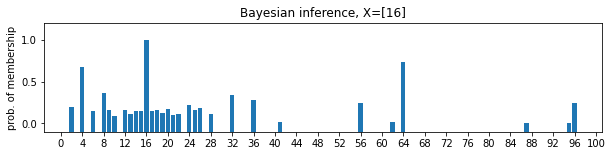

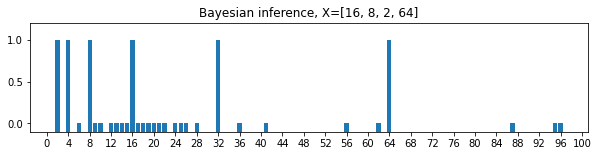

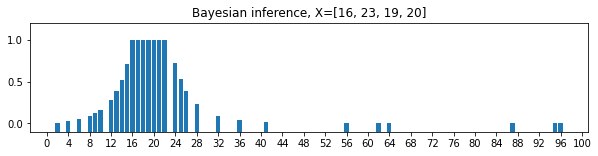

In [40]:
H_all,log_prior_all = generate_hypotheses(mylambda=2./3)
x_eval = [2,4,6,8,9,10]+list(range(12,23))+[24,25,26,28,32,36,41,56,62,64,87,95,96]

mypred = bayesian_predictions(x_eval, [16], H_all, log_prior_all)
plot_predictions(x_eval,mypred)
plt.title('Bayesian inference, X=[16]')
plt.ylabel('prob. of membership')
mypred = bayesian_predictions(x_eval, [16, 8, 2, 64], H_all, log_prior_all)
plot_predictions(x_eval,mypred)
plt.title('Bayesian inference, X=[16, 8, 2, 64]')
mypred = bayesian_predictions(x_eval, [16, 23, 19, 20], H_all, log_prior_all)
plot_predictions(x_eval,mypred)
plt.title('Bayesian inference, X=[16, 23, 19, 20]')
plt.show()

<div class="alert alert-success" role="alert">
<h3> Problem 5 (10 points) </h3>
<br>
Using the code above, produce plots the show the Bayesian model's predictions. Produce the plots for the default `mylambda = 2./3`, but also reproduce the plots below for another value of `mylambda` that shows qualitatively different results. 
<ul>
    <li>Which value of `mylambda` seems to capture the human behavior data the best?</li>
    <li>Comment on why the predictions change for different values of `mylambda`.</li>
</ul>
<br>
Your response in the cells below should include plots for a least one new setting of lambda, and 1-2 paragraphs of discussion about how the results change as a function of `mylambda`.
</div>

YOUR RESPONSE GOES HERE

The closer mylambda is to 0.5, the better the Bayesian model captures the human behavior.

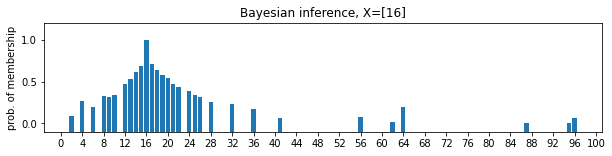

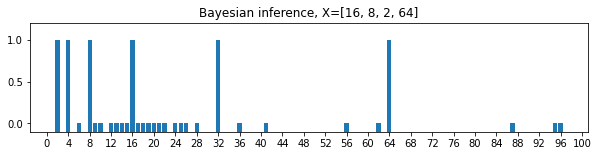

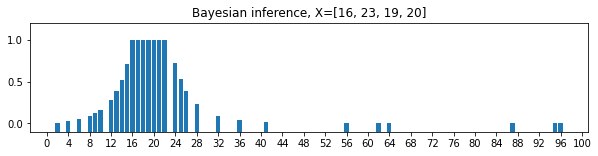

In [41]:
H_all,log_prior_all = generate_hypotheses(mylambda=0.1)
x_eval = [2,4,6,8,9,10]+list(range(12,23))+[24,25,26,28,32,36,41,56,62,64,87,95,96]

mypred = bayesian_predictions(x_eval, [16], H_all, log_prior_all)
plot_predictions(x_eval,mypred)
plt.title('Bayesian inference, X=[16]')
plt.ylabel('prob. of membership')
mypred = bayesian_predictions(x_eval, [16, 8, 2, 64], H_all, log_prior_all)
plot_predictions(x_eval,mypred)
plt.title('Bayesian inference, X=[16, 8, 2, 64]')
mypred = bayesian_predictions(x_eval, [16, 23, 19, 20], H_all, log_prior_all)
plot_predictions(x_eval,mypred)
plt.title('Bayesian inference, X=[16, 23, 19, 20]')
plt.show()

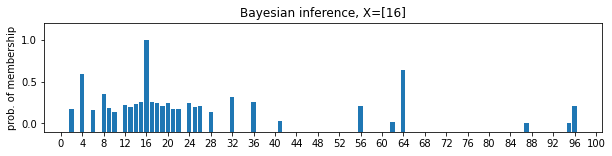

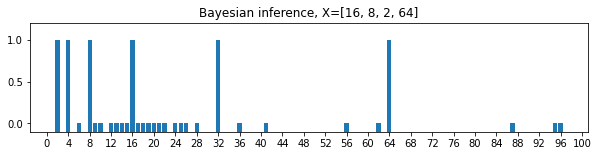

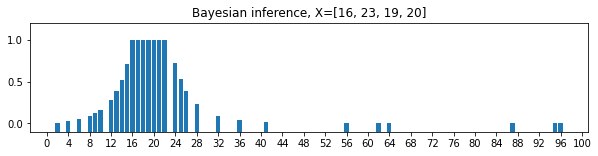

In [44]:
H_all,log_prior_all = generate_hypotheses(mylambda=0.5)
x_eval = [2,4,6,8,9,10]+list(range(12,23))+[24,25,26,28,32,36,41,56,62,64,87,95,96]

mypred = bayesian_predictions(x_eval, [16], H_all, log_prior_all)
plot_predictions(x_eval,mypred)
plt.title('Bayesian inference, X=[16]')
plt.ylabel('prob. of membership')
mypred = bayesian_predictions(x_eval, [16, 8, 2, 64], H_all, log_prior_all)
plot_predictions(x_eval,mypred)
plt.title('Bayesian inference, X=[16, 8, 2, 64]')
mypred = bayesian_predictions(x_eval, [16, 23, 19, 20], H_all, log_prior_all)
plot_predictions(x_eval,mypred)
plt.title('Bayesian inference, X=[16, 23, 19, 20]')
plt.show()

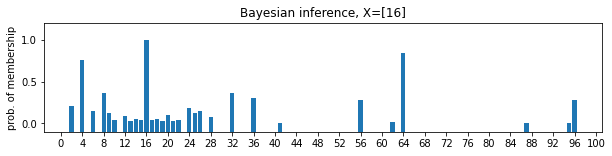

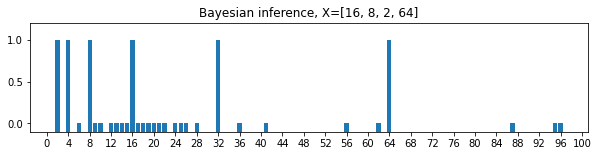

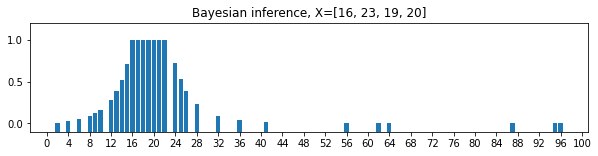

In [42]:
H_all,log_prior_all = generate_hypotheses(mylambda=0.9)
x_eval = [2,4,6,8,9,10]+list(range(12,23))+[24,25,26,28,32,36,41,56,62,64,87,95,96]

mypred = bayesian_predictions(x_eval, [16], H_all, log_prior_all)
plot_predictions(x_eval,mypred)
plt.title('Bayesian inference, X=[16]')
plt.ylabel('prob. of membership')
mypred = bayesian_predictions(x_eval, [16, 8, 2, 64], H_all, log_prior_all)
plot_predictions(x_eval,mypred)
plt.title('Bayesian inference, X=[16, 8, 2, 64]')
mypred = bayesian_predictions(x_eval, [16, 23, 19, 20], H_all, log_prior_all)
plot_predictions(x_eval,mypred)
plt.title('Bayesian inference, X=[16, 23, 19, 20]')
plt.show()

# Making maximum a posteriori (MAP) predictions
As implemented above, to make proper Bayesian predictions, we marginalize (average) over all of our hypotheses weighted by our posterior belief.

\begin{equation}
P(y \in C\ |\ X) = \sum_{h \in H} P(y \in C\ |\ h) P(h|X).
\end{equation}

However, the summation over all hypotheses isn't always tractable (although it is in this case). A common approximation to full Bayesian inference is called maximum a posteriori (MAP) inference: making predictions based on just the best hypothesis $h^*$, as determined by its score under the posterior distribution.

\begin{equation}
h^* = \text{argmax}_{h \in H} P(h^*|X).
\end{equation}

Then, predictions are made as follows:

\begin{equation}
P(y \in C\ |\ X) \approx P(y \in C\ |\ h^*).
\end{equation}

In essence, we pretend that there is only one term in our hypotheses average. This can be a good approximation if just one hypothesis is dominant in the posterior. Otherwise, it can be a poor approximation.

<div class="alert alert-success" role="alert">
<h3> Problem 6 (10 points) </h3>
<br>
<li>Fill in the missing code below to help complete the `MAP_predictions` function.</li></div>

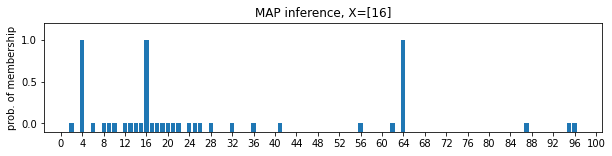

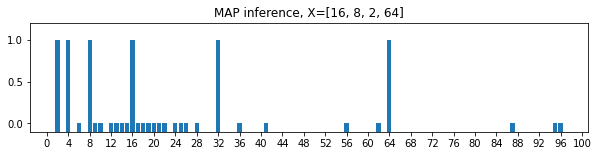

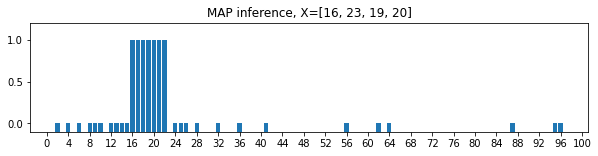

In [47]:
def MAP_predictions(data_eval, data, list_hypothesis, log_prior):
    # INPUT
    #  data_eval : [length ne python list] of new numbers we want to check the probability of membership for
    #     each number in data_eval is to be evaluated independently -- it's a separate 'y' in equation above
    #  data : [python list] observed numbers (X) 
    #  list_hypothesis : python list of hypotheses, each is a binary numpy array 
    #  log_prior : numpy vector [length nh] which is the log prior value for each hypothesis
    # 
    # RETURN
    #  pp : numpy vector [size ne] of predicted probabilities of new numbers in data_eval (NOTE: NOT IN LOG SPACE)
    lpost = log_posterior(data,list_hypothesis,log_prior)
    ne = len(data_eval) # how many numbers to evaluate
    pp = np.zeros(ne) # predicted probability of each number
    #TODO : Add your code here to compute MAP approximation
    # raise Exception('Replace with your code.')
    
    lpost = log_posterior(data,list_hypothesis,log_prior)
    post = np.exp(lpost) # posterior probabilities
    hyp_max = list_hypothesis[np.argmax(post)]
    #h_mat = np.array(list_hypothesis) # create a [nh by x_max] numpy matrix, showing numbers in each hypothesis
    ne = len(data_eval) # how many numbers to evaluate
    pp = np.zeros(ne) # predicted probability of each number
    
    
    for idx,de in enumerate(data_eval):
        #TODO : Add your code here to compute predicted probabilities. Can be a single line with form "pp[idx] = "..
        #raise Exception('Replace with your code.')
        if hyp_max[de] == 1:
            pp[idx] = 1
    return pp

H_all,log_prior_all = generate_hypotheses(mylambda=2./3)
x_eval = [2,4,6,8,9,10]+list(range(12,23))+[24,25,26,28,32,36,41,56,62,64,87,95,96]

mypred = MAP_predictions(x_eval, [16], H_all, log_prior_all)
plot_predictions(x_eval,mypred)
plt.title('MAP inference, X=[16]')
plt.ylabel('prob. of membership')
mypred = MAP_predictions(x_eval, [16, 8, 2, 64], H_all, log_prior_all)
plot_predictions(x_eval,mypred)
plt.title('MAP inference, X=[16, 8, 2, 64]')
mypred = MAP_predictions(x_eval, [16, 23, 19, 20], H_all, log_prior_all)
plot_predictions(x_eval,mypred)
plt.title('MAP inference, X=[16, 23, 19, 20]')
plt.show()

<div class="alert alert-success" role="alert">
<h3> Problem 7 (5 points) </h3>
<br>
Using the code above, produce plots that show the model's predictions using the MAP approximation. Is MAP inference or full Bayesain inference a better account of the human behavioral data in this experiment? Why? Your answer should just be a few sentences.
</div>

YOUR RESPONSE GOES HERE

Full Bayesian inference is a better account of the human behavioral data because human cognition often times doesn't just rely on a single hypothesis. As a result, the combination of math and interval hypotheses gave the closest prediction to human behavioral data. When we only account for the hypothesis with maximum probability, it is possible to miss an important part of the data. Since full Bayesian inference takes into account more data and information, it is closer to how human cognition behavior.

<div class="alert alert-success" role="alert">
<h3> Problem 8 (10 points) </h3>
<br>
Discuss your general thoughts on this Bayesian model to understand human judgments in the number game. Discussion questions could include the following (as well as others):
<ul>
    <li>Is the model convincing? Why or why not?</li>
    <li>Is the number game and Bayesian model relevant to more naturalistic settings for concept learning in childhood or everyday life?</li>
    <li>Where could the hypothesis space come from?</li>
    <li>What algorithms could people be using to approximate Bayesian inference, rather than enumerating all the hypotheses, as in the current implementation?</li>
</ul>
<br>
Please write a short response in the cell below. Your response should be about two paragraphs.
</div>

YOUR RESPONSE GOES HERE

I believe this model is convincing in its ability to understand human judgment because the inference graphs are able to closely resemble the human prediction probability graphs. This result makes sense because the numbers game is similar to how humans learn from the environments in childhood and even in the adult stages of life. With the vast amount of varying factors that govern the society, it is impossible for humans to have all the necessary information; instead, we are forced to make predictions based on our previous experiences and update our decision making. This process is very similar to Bayesian modeling involving prior, likelihood, and posterior, where we use prior knowledge to improve decision making with likelihood and finally find the posterior probability. Since process is very similar to human decision making, Bayesian is able to capture the human behavior in a convincing level.

Important part of Bayesian process is hypothesis space. In terms of human behavior, hypothesis space is developed from the experiences and memories that can possibly match with the phenomenon observed (i.e. output numbers in the number game). Since machines cannot clearly know which hypothesis space to use and incorporate, we manually input the hypotheses in the Bayesian model. However, using algorithms like KNN and clustering, we may be able to approximate Bayesian inference rather than enumerating all the hypotheses.

<div class="alert alert-success" role="alert">
<h3> Problem 9 (20 points)</h3>
<br>
Here we consider a sampling-based strategy to approximate full Bayesian inference (as opposed to the cruder MAP approximation). This problem asks you to implement a "likelihood weighted sampler" as discussed in lecture. Review the lecture notes on importance sampling and specifically "likelihood weighted sampling", where we choose the approximate distribution Q to be the prior distribution over hypotheses.
<ul>
    <li>Fill in the missing code below to help complete the `draw_prior_samples`, `weight_samples`, and `importance_sampler_predictions` functions.</li>
    <li>Run your likelihood weighted sampler for 2000 samples and reproduce the plots in Problem 5. Does approximate inference match the exact inference?</li>
</ul>
</div>

Approximate inference does match the exact inference.

<Figure size 432x288 with 0 Axes>

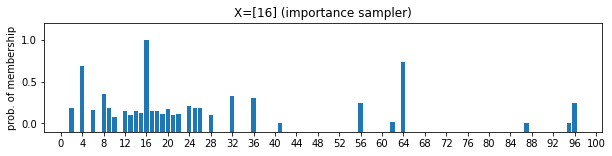

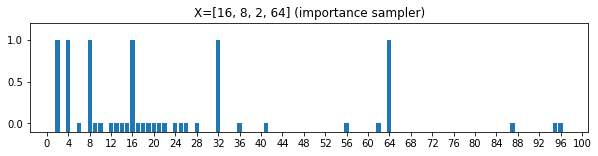

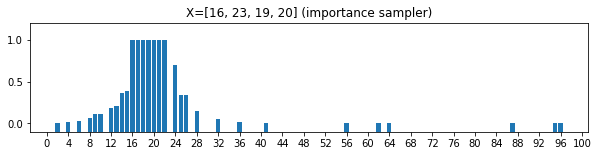

In [49]:
def draw_prior_samples(nsamp):
    # INPUT
    #  nsamp : number of hypotheses to be sampled from the prior
    #
    # RETURN
    #  list_H : [nsamp length python list] of sampled hypotheses (each is a binary numpy vector [length x_max])
    #
    # TODO: Add your code to draw a list of samples (from H_all) given their prior probabilities (log_prior_all)
    # raise Exception('Replace with your code.')
    H_all, log_prior_all = generate_hypotheses(mylambda=2./3)
    sample=np.random.choice(len(H_all), size=nsamp, replace=True, p=np.exp(log_prior_all))
    list_H = []
    for i in sample:
        list_H.append(H_all[i])
    return list_H

def weight_samples(data, list_H):
    # INPUT
    #  data : [python list] of observed data
    #  list_H : [nsamp length pythong list] of sampled hypotheses (each is a binary numpy vector [length x_max])
    #     these are the sampled "particles" in the importance sampler
    #
    # Output
    #  log_wt : numpy vector [size nsamp] log importance weight of each sample in list_H
    #
    # TODO: Add your code to return the log-weight of each particle
    # raise Exception('Replace with your code.')
    log_wt = []
    for hyp in list_H:
        log_wt.append(log_likelihood(convert_h_list_to_numpy(data),hyp))
    return log_wt

def importance_sampler_predictions(data_eval, list_H, log_wt):
    # INPUT
    #  data_eval : [length ne python list] of new numbers we want to evaluate the probability of membership for 
    #     each number in data_eval is to be evaluated independently (as in bayesian_predictions function)
    #  list_H : nsamp length pythong list] of sampled hypotheses (each is a binary numpy vector [length x_max])
    #  log_wt : numpy vector [size nsamp] log importance weight of each sample in list_H
    # 
    # RETURN
    #  pp : numpy vector [size ne] of predicted probabilities of new numbers  (NOTE: NOT IN LOG SPACE)
    wt = np.exp(log_wt)
    h_mat = np.array(list_H) # create a [nsamp by x_max] numpy matrix, showing numbers in each hypothesis/sample
    ne = len(data_eval) # how many numbers to evaluate
    pp = np.zeros(ne) # predicted probability of each number
    for idx,de in enumerate(data_eval):
        #TODO : Add your code here/ Can be a single line with form "pp[idx] = "..
        # raise Exception('Replace with your code.')
        predicted_prob = 0
        for i, hypothesis in enumerate(h_mat):
            if h_mat[i][de] == 1:
                predicted_prob += wt[i]
        pp[idx] = predicted_prob / np.sum(wt)
        
    return pp
    
nsamples_importance = 2000 # number of samples
plt.figure()
list_H_importance = draw_prior_samples(nsamples_importance) # prior samples can be re-used across queries
log_wt_importance = weight_samples([16],list_H_importance)
mypred = importance_sampler_predictions(x_eval, list_H_importance, log_wt_importance)
plot_predictions(x_eval,mypred)
plt.title('X=[16] (importance sampler)')
plt.ylabel('prob. of membership')

log_wt_importance = weight_samples([16, 8, 2, 64],list_H_importance)
mypred = importance_sampler_predictions(x_eval, list_H_importance, log_wt_importance)
plot_predictions(x_eval,mypred)
plt.title('X=[16, 8, 2, 64] (importance sampler)')

log_wt_importance = weight_samples([16, 23, 19, 20],list_H_importance)
mypred = importance_sampler_predictions(x_eval, list_H_importance, log_wt_importance)
plot_predictions(x_eval,mypred)
plt.title('X=[16, 23, 19, 20] (importance sampler)')
plt.show()